# EDA

In [2]:
import os
import torch
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact

import plotly.graph_objects as go

from tqdm import tqdm

## Data Visualization

In [2]:
# paths
train_im_dir = "dataset/Task02_Heart/raw/imagesTr"
train_la_dir = "dataset/Task02_Heart/raw/labelsTr"

In [3]:
im_slice = 70
# load an example of image
image_3d = np.load(os.path.join(train_im_dir, sorted(os.listdir(train_im_dir))[0]))
image_2d = image_3d[im_slice]
# load an example of label
label_3d = np.load(os.path.join(train_la_dir, sorted(os.listdir(train_la_dir))[0]))
label_2d = label_3d[im_slice]

In [4]:
# print the shape of the image and label
print(f"Image shape: {image_3d.shape}")
print(f"Label shape: {label_3d.shape}")

Image shape: (130, 320, 320)
Label shape: (130, 320, 320)


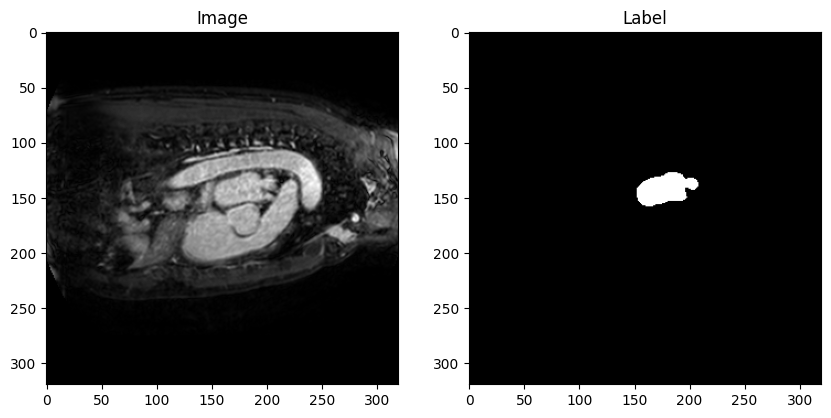

In [5]:
# visualize the image and label side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image_2d, cmap="gray")
ax[0].set_title("Image")
ax[1].imshow(label_2d, cmap="gray")
ax[1].set_title("Label")

plt.show()

In [6]:
# print the value range of the image and label
print(f"Image value range: {np.min(image_3d)} - {np.max(image_3d)}")
print(f"Label value range: {np.min(label_3d)} - {np.max(label_3d)}")

# print the unique values of the label
print(f"Label unique values: {np.unique(label_3d)}")

# print label distribution
print(f"Label distribution: {np.unique(label_3d, return_counts=True)[1]}")

Image value range: 0.0 - 1999.0
Label value range: 0.0 - 1.0
Label unique values: [0. 1.]
Label distribution: [13266997    45003]


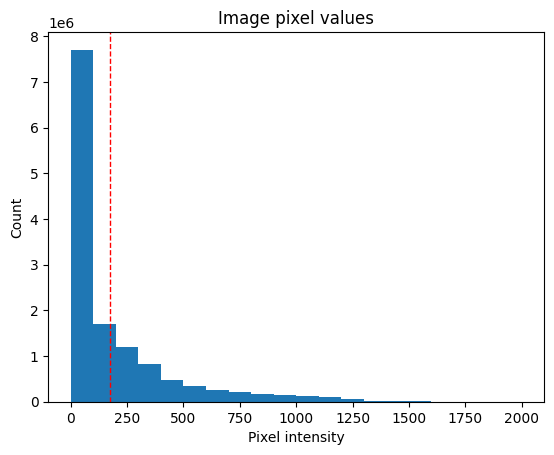

In [7]:
# plot the histogram of the 3d image pixel values
plt.hist(image_3d.flatten(), bins=20)
plt.title("Image pixel values distribution")
plt.xlabel("Pixel intensity")
plt.ylabel("Count")
plt.axvline(image_3d.mean(), color="r", linestyle="dashed", linewidth=1)
plt.show()

In [8]:
# normalize the image
image_3d_norm = (image_3d - image_3d.mean()) / image_3d.std()

# rescale the image to [0, 1]
image_3d_norm = (image_3d_norm - np.min(image_3d_norm)) / (np.max(image_3d_norm) - np.min(image_3d_norm))

print(f"Normalized image value range: {np.min(image_3d_norm)} - {np.max(image_3d_norm)}")

Normalized image value range: 0.0 - 1.0


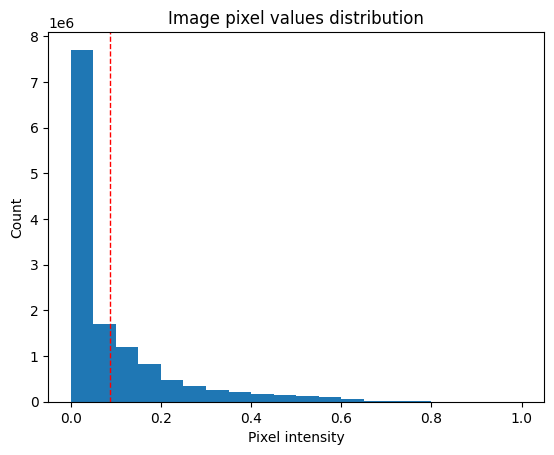

In [14]:
# plot the histogram of the 3d normalized image pixel values
plt.hist(image_3d_norm.flatten(), bins=20)
plt.title("Image pixel values distribution")
plt.xlabel("Pixel intensity")
plt.ylabel("Count")
plt.axvline(image_3d_norm.mean(), color="r", linestyle="dashed", linewidth=1)
plt.show()

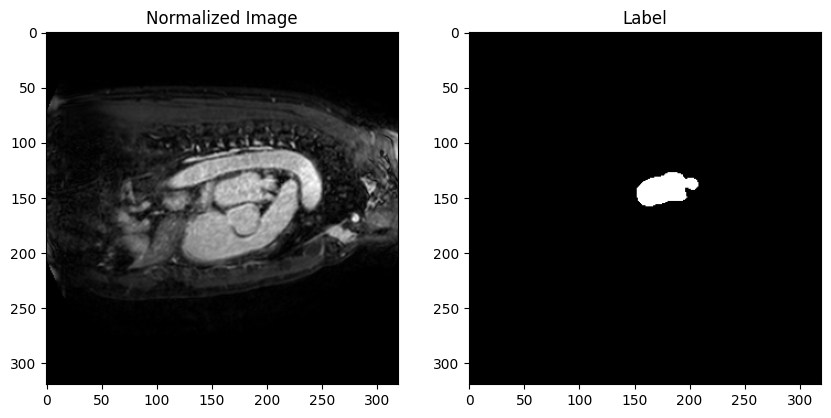

In [9]:
# visualize the normalized image and label side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image_3d_norm[im_slice], cmap="gray")
ax[0].set_title("Normalized Image")
ax[1].imshow(label_2d, cmap="gray")
ax[1].set_title("Label")

plt.show()

In [27]:
# visualize the normalized image and label overlaid with each other (alpha=0.5)
def visualize_image_label_3d(image, label):
    @interact
    def plot_slice(slice=(1, image.shape[0]-1, 1)):
        fig, ax = plt.subplots(1, 1)
        ax.imshow(image[slice], cmap="gray")
        ax.imshow(label[slice], cmap="jet", alpha=0.3)
        ax.set_title(f"Slice {slice}")
        plt.show()

In [ ]:
visualize_image_label_3d(image_3d_norm, label_3d)

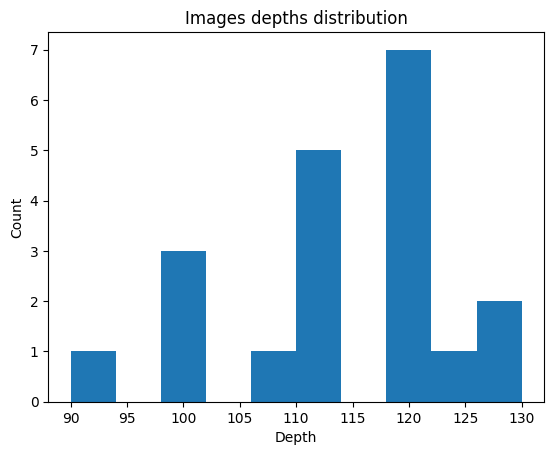

In [13]:
# histogram of the images depths
plt.hist([np.load(os.path.join(train_im_dir, image_3d)).shape[0] for image_3d in os.listdir(train_im_dir)], bins=10)
plt.title("Images depths distribution")
plt.xlabel("Depth")
plt.ylabel("Count")

plt.show()

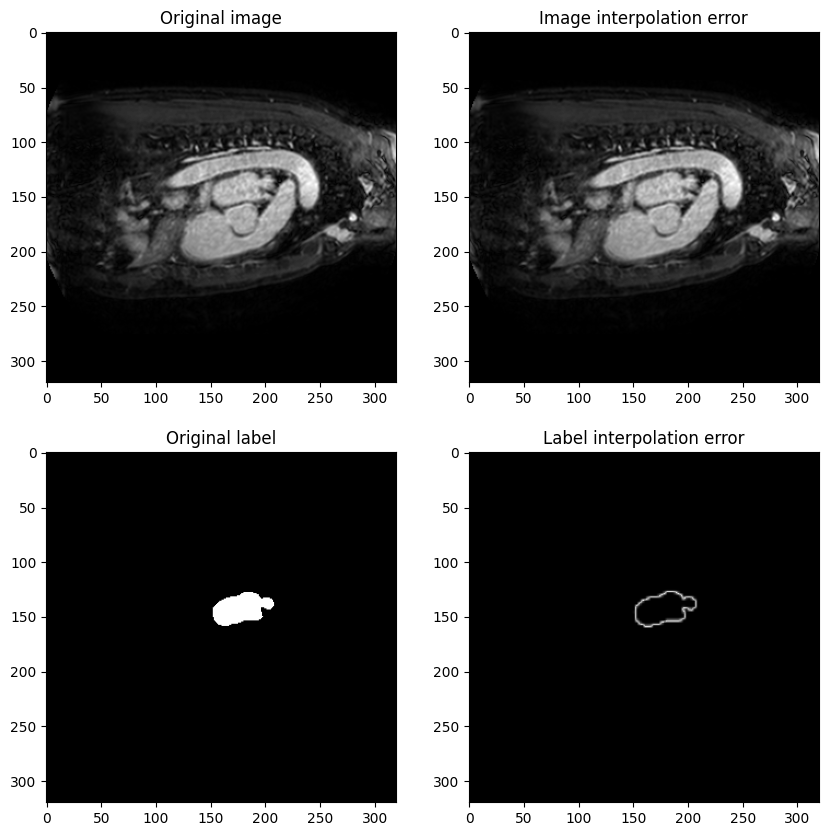

In [37]:
# effect of reshaping the image to 128x128x128
image_3d_tensor = torch.from_numpy(image_3d).unsqueeze(0).unsqueeze(0).float()
label_3d_tensor = torch.from_numpy(label_3d).unsqueeze(0).unsqueeze(0).float()
image_3d_tensor_128 = torch.nn.functional.interpolate(image_3d_tensor, size=(128, 128, 128), mode="trilinear")
label_3d_tensor_128 = torch.nn.functional.interpolate(label_3d_tensor, size=(128, 128, 128), mode="trilinear")
image_3d_tensor_320 = torch.nn.functional.interpolate(label_3d_tensor_128, size=(image_3d_tensor.shape[2], 320, 320), mode="trilinear")
label_3d_tensor_320 = torch.nn.functional.interpolate(label_3d_tensor_128, size=(label_3d_tensor.shape[2], 320, 320), mode="trilinear")

# visualize the absolute difference between the original and the reshaped image and label
s = 70
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(image_3d_tensor.squeeze().numpy()[s], cmap="gray")
ax[0, 0].set_title("Original image")
ax[0, 1].imshow(np.abs(image_3d_tensor.squeeze().numpy()[s] - image_3d_tensor_320.squeeze().numpy()[s]), cmap="gray")
ax[0, 1].set_title("Image interpolation error")
ax[1, 0].imshow(label_3d_tensor.squeeze().numpy()[s], cmap="gray")
ax[1, 0].set_title("Original label")
ax[1, 1].imshow(np.abs(label_3d_tensor.squeeze().numpy()[s] - label_3d_tensor_320.squeeze().numpy()[s]), cmap="gray")
ax[1, 1].set_title("Label interpolation error")

plt.show()

## Data Interpolation

In [44]:
# convert the normalized image to torch tensor
image_3d_tensor = torch.from_numpy(image_3d_norm).unsqueeze(0).unsqueeze(0).float()
label_3d_tensor = torch.from_numpy(label_3d).unsqueeze(0).unsqueeze(0).float()

# print shapes
print(f"Image shape: {image_3d_tensor.shape}")
print(f"Label shape: {label_3d_tensor.shape}")

# resize the image and label to 128x128x128
resize_shape = (128, 128, 128)
image_3d_tensor_interpolated = torch.nn.functional.interpolate(image_3d_tensor, size=resize_shape, mode="trilinear")
label_3d_tensor_interpolated = torch.nn.functional.interpolate(label_3d_tensor, size=resize_shape, mode="trilinear")

# print new shapes
print(f"Image shape interpolated: {image_3d_tensor_interpolated.shape}")
print(f"Label shape interpolated: {label_3d_tensor_interpolated.shape}")


Image shape: torch.Size([1, 1, 130, 320, 320])
Label shape: torch.Size([1, 1, 130, 320, 320])
Image shape interpolated: torch.Size([1, 1, 128, 128, 128])
Label shape interpolated: torch.Size([1, 1, 128, 128, 128])


In [46]:
# visualize the image and label after interpolation
visualize_image_label_3d(image_3d_tensor_interpolated[0][0], label_3d_tensor_interpolated[0][0])

interactive(children=(IntSlider(value=64, description='slice', max=127, min=1), Output()), _dom_classes=('widg…

## Extra

In [3]:
# paths
train_im_dir = "dataset/original/Task01_BrainTumour/imagesTr"
train_la_dir = "dataset/original/Task01_BrainTumour/labelsTr"

In [28]:
im_slice = 70
# load an example of image
image_4d = nib.load(os.path.join(train_im_dir, sorted(os.listdir(train_im_dir))[0])).get_fdata()
# load an example of label
label_3d = nib.load(os.path.join(train_la_dir, sorted(os.listdir(train_la_dir))[0])).get_fdata()

In [29]:
im1_3d = image_4d[:, :, :, 0]
im2_3d = image_4d[:, :, :, 1]
im3_3d = image_4d[:, :, :, 2]
im4_3d = image_4d[:, :, :, 3]
print("Image 1 shape: ", im1_3d.shape)
print("Image 2 shape: ", im2_3d.shape)
print("Image 3 shape: ", im3_3d.shape)
print("Image 4 shape: ", im4_3d.shape)

Image 1 shape:  (240, 240, 155)
Image 2 shape:  (240, 240, 155)
Image 3 shape:  (240, 240, 155)
Image 4 shape:  (240, 240, 155)


In [30]:
# transpose the image and label to have the depth as the first dimension
im1_3d = np.transpose(im1_3d, (2, 0, 1))
im2_3d = np.transpose(im2_3d, (2, 0, 1))
im3_3d = np.transpose(im3_3d, (2, 0, 1))
im4_3d = np.transpose(im4_3d, (2, 0, 1))
label_3d = np.transpose(label_3d, (2, 0, 1))
print("Image 1 shape: ", im1_3d.shape)
print("Image 2 shape: ", im2_3d.shape)
print("Image 3 shape: ", im3_3d.shape)
print("Image 4 shape: ", im4_3d.shape)

Image 1 shape:  (155, 240, 240)
Image 2 shape:  (155, 240, 240)
Image 3 shape:  (155, 240, 240)
Image 4 shape:  (155, 240, 240)


In [31]:
# visualize the image and label of 4d images
visualize_image_label_3d(im1_3d, label_3d)

interactive(children=(IntSlider(value=77, description='slice', max=154, min=1), Output()), _dom_classes=('widg…

In [32]:
# visualize the image and label of 4d images
visualize_image_label_3d(im2_3d, label_3d)

interactive(children=(IntSlider(value=77, description='slice', max=154, min=1), Output()), _dom_classes=('widg…

In [33]:
# visualize the image and label of 4d images
visualize_image_label_3d(im3_3d, label_3d)

interactive(children=(IntSlider(value=77, description='slice', max=154, min=1), Output()), _dom_classes=('widg…

In [34]:
# visualize the image and label of 4d images
visualize_image_label_3d(im4_3d, label_3d)

interactive(children=(IntSlider(value=77, description='slice', max=154, min=1), Output()), _dom_classes=('widg…

## Preprocessing nnUNet

In [1]:
import sys
sys.path.append('utils')

from utils.data_utils import convert_niigz_to_numpy

convert_niigz_to_numpy('dataset/original/Task04_Hippocampus')

100%|██████████| 130/130 [00:01<00:00, 117.86it/s]


In [38]:
import sys
sys.path.append('preprocessing')

from preprocessing.preprocess import preprocess_data

preprocess_data("dataset/original/Task01_BrainTumour")